# Frequent Itemsets

By Linus Östlund and Daniel Workinn

In this homework we implement one of the major families of techniques for characterizing data - discovering `Frequent Itemsets` and `Association Rules`.  

To discover `Frequent Itemsets` we have implemented the `A-Priori Algorithm` by following the guidelines in the course litterature. 

We then use the frequent itemsets to mine `Association Rules`. The association rules quantify the conditional probability of item `j` existing in the basket given itemset `I` (I -> J). Association rules can be used by e.g. a retailer to learn what items are commonly bought together. 

## Implementation

First, read the data from the file and create a list of baskets (also called *transactions*).

In [36]:
def import_baskets(path_to_data):
    with open(path_to_data) as f:
        lines = f.readlines()
        baskets = [set(map(int, line.strip().split(sep=' '))) for line in lines]
    return baskets

def get_unique_items(baskets):
    """
    Helper method to get the number of unique items in the baskets-dataset.
    """
    return set.union(*baskets)

def get_number_of_baskets(baskets):
    """
    Helper method to get the number of baskets. But you can also use len(baskets) 😂 I walk over the å to get the vatten.
    """
    return len(baskets)

We proceed with loading all baskets into a list of sets, where each set is a basket.

In [37]:
# NOTE: this could differ depending on what OS you are using (I'm on a Mac M1)
path_to_data = '../data/baskets.dat'

baskets = import_baskets(path_to_data)

print(f'Number of unique items: {len(get_unique_items(baskets))}')
print(f'Number of baskets: {len(baskets)}')

Number of unique items: 870
Number of baskets: 100000


For the creation of `L`<sub>`1`</sub> (frequent singletons) we use a dictionary that maps each item to the baskets it is in:
    
```python
    {
    0: [1,2,3], # item 0 is in baskets 1, 2 and 3
    1: [2, 3],  # item 1 is in baskets 2 and 3
    # and so on
    }
```

In [38]:
# get item and basket dictionary
def item_and_basket_dictionary(baskets):
    """
    Returns a dictionary with each each item as a key, and a list of all basket it appears in as a value.
    """
    # set up keys as all unique items
    keys = get_unique_items(baskets)

    # values will be lists of basket's number where they occur
    values = [[] for _ in range(len(get_unique_items(baskets)))]

    items = dict(zip(keys, values))

    # populate the dictionary
    for i, basket in enumerate(baskets):
        for item in basket:
            items[item].append(i)
    return items

The above dictionary is then used to find the support (in absolute number) for each singleton item by counting the number of baskets it is in.

In [39]:
# 'singletons' is the support for all singletons
singletons = {k: len(v) for k, v in item_and_basket_dictionary(baskets).items()}

Next is the filter step, and removing all items that do not meet the minimum support threshold:

$ \text{Minimum support} = 0.01 * \texttt{len(baskets)} $, in this case $0.01 * 100 000 = 1000$.

The result is `L`<sub>`1`</sub> - Frequent Singletons.

In [40]:
# set threshold as suggested in lecture
threshold = 0.01

# filter out all singletons with support below threshold
frequent_singletons = {k: v for k, v in singletons.items() if v / len(baskets) >= threshold}

# print the number of frequent singletons
print(f'Number of significant singletons: {len(frequent_singletons)} with a threshold of {threshold} (minimum support of {int(threshold * len(baskets))})')

Number of significant singletons: 375 with a threshold of 0.01 (minimum support of 1000)


For the second pass of the Apriori algorithm, we need a method to generate candidate itemsets. To this end, the course literature suggests the following:

> **From course literature (p.226):** During the second pass, we count all the pairs that *consists of two frequent items*. We call this table *frequent-items table*.

We then check if the pair is frequent, and if it is, we add it to the set of frequent itemsets.
The algorithm for generating candidate itemsets is as follows:

In [41]:
import numpy as np

def get_frequent_items_table(baskets, frequent_items):
    """
    Returns a table of frequent items, where each row is a frequent item and each column is a basket.
    frequent_items is a list where all frequent singletons has a uniqe m-value.
    """
    # NOTE there are 870 uniqe items assigned to integers [0, 1000]. 
    # This step is usually done by as a first step in the apriori alogoritm.
    frequent_items_table = np.zeros((max(map(max, baskets))) + 1, dtype=int)
    # assign 'm' as a unique values, used to mark the frequent items
    m = 0
    # identify all frequent items
    for item in frequent_items:
        # NOTE why dont we just use boolean values, is there a reason to use integers?
        frequent_items_table[item] = m
        m += 1
    return frequent_items_table

The Apriori algorithm requires some more methods; we have the candidate $k$-tuples are frequent.

We still follow the outline as suggested in the course literature (p.226):

> 1. For each basket, look in the frequent-items table to see which of its items are frequent.
> 2. In a double loop, generate all pairs of frequent items in that basket.
> 3. For each such pair, add one to its count in the data structure used to store counts.

So we are going to look through each basket, and, by using the previous pass frequent items,filter a subset of the items to produce all combinations. The we store those in a dictionary, and increment the count for each combination. This approach is a bit different from the one found in the 1994 paper, as they propose generating all combinations from items in the previous pass. Our approach it is more efficient.

To generate all unordered pairs of frequent items in a basket, we use the `combinations` function from the `itertools` library. We use `frozensets` since they are a hashable type, and can be used as keys in a dictionary.

In [42]:
from itertools import combinations

def filter_frequent_items_in_basket(basket, frequent_items_table):
    """
    [HELPER FUNCTION] Return the frequent items in a basket.
    """
    return [item for item in basket if frequent_items_table[item] != 0]

def generate_all_combinations(items, k=2):
    """
    [HELPER FUNCTION] Generate all pairs of frequent items in a basket.
    """
    return [frozenset(pair) for pair in combinations(items, k)]

def find_candidate_tuples(baskets, frequent_items_table, k=2):
    """
    Find all candidate k-tuples of frequent items.
    """
    candidate_pairs = {}
    for basket in baskets:
        # filter out all frequent items in the basket
        frequent_items_in_basket = filter_frequent_items_in_basket(basket, frequent_items_table)
        # genereate all combinations of frequent items in the basket
        basket_pairs = generate_all_combinations(frequent_items_in_basket, k=k)
        for pair in basket_pairs:
            if pair not in candidate_pairs:
                candidate_pairs[pair] = 1
            else:
                candidate_pairs[pair] += 1
    return candidate_pairs


def filter_candidate_tuples(baskets, candidates, threshold):
    """
    Filter out all candidate k-tuples that do not meet the threshold.
    """
    #return dict(filter(lambda x: x[1] >= threshold, candidate_pairs.items())) # TODO är filter bättre?
    return {pair: freq for pair, freq in candidates.items() if freq >= threshold*len(baskets)}

## The Apriori algorithm
The `apriori()`-function mimic the pseudocode from the 1994 article. In order to speed up the algorithm, we use the suggested approach in the course literature, and use the frequent-items table to filter out infrequent items in all paskets. We then produce all $k$-tuples using the remaining (frequent) items. This assumption holds due to the *monotonicity of itemsets*.

### Monotonicity of Itemsets

According to the paper and ch 6 of the course literature, the effectiveness of the Apriori algorithm depends on the monotonicity of the itemsets. 

> **Definition**: If a set $I$ of items is frequent, then so is the powerset of $I$ are also frequent (remember, the **powerset of $I$ is the set of all subsets of $I$**)

For example, if the itemset $I = \{1, 2, 3\}$ is frequent, then so are *all* subsets, $\mathscr{P}(I) = \{\{1\}, \{2\}, \{3\}, \{1, 2\}, \{1, 3\}, \{3, 2\}\}$, of $I$.

In [43]:
def apriori(baskets, singletons, threshold=0.01):
    """
    Find frequent itemsets using the Apriori algorithm.
    L1 ("Large 1-tons") is a frozenset of frequent singletons and their frequencies.
    """
    # find frequent singletons
    frequent_singletons = {k: v for k, v in singletons.items() if v / len(baskets) >= threshold}
    # convert to a frozenset
    L1 = frozenset(frequent_singletons.keys())
    # set up initial values
    k, L = 2, L1
    # this while-loop is just like the pipeline in the lecture
    while True:
        # genereate frequent-items table
        fit = get_frequent_items_table(baskets, L)
        # find all candidate pairs
        candidates = find_candidate_tuples(baskets, fit, k=k)
        # filter candidate pairs
        filtered_candidates = filter_candidate_tuples(baskets=baskets, candidates=candidates, threshold=threshold)
        # if no filter candidate pairs, break loop
        if len(filtered_candidates) == 0:
            break
        # else, set L to filtered candidates
        print(f'Number of {k}-tuples: {len(filtered_candidates)}')
        print(f'Number of unique items in {k}-tuples: {len(frozenset.union(*filtered_candidates))}\n')
        L = frozenset.union(*filtered_candidates.keys())
        k += 1

The method does what the pipeline suggest, and break the problem into smaller, handlable chunks.

![Apriori pipeline](../imgs/apriori_pipeline.jpeg)

In [44]:
apriori(baskets, singletons, threshold=threshold)

Number of 2-tuples: 9
Number of unique items in 2-tuples: 12



Now we collect all of the above methods in one neat class that stores all results in a dictionary called `frequent_itemsets`
```python
# one line to rule them all
frequent_itemsets = Apriori(baskets, min_support=0.01).frequent_itemsets
```

In [45]:
import numpy as np
from itertools import combinations

class Apriori:
    def __init__(self, baskets, threshold=0.01):
        self.threshold = threshold
        self.max_item_id = 0
        singletons = {k: len(v) for k, v in self.item_and_basket_dictionary(baskets).items()}
        self.frequent_itemsets = self.apriori(baskets=baskets, singletons=singletons, threshold=self.threshold)

    def get_unique_items(self, baskets):
        """
        [HELPER METHOD] Get the number of unique items in the baskets-dataset.
        """
        return set.union(*baskets)
        
    def item_and_basket_dictionary(self, baskets):
        """
        Returns a dictionary with each each item as a key, 
        and a list of all baskets it appears in as a value.
        """
        # set up keys as all unique items
        keys = self.get_unique_items(baskets)
        self.max_item_id = max(keys)

        # values will be lists of basket's number where they occur
        values = [[] for _ in range(len(get_unique_items(baskets)))]

        items = dict(zip(keys, values))

        # populate the dictionary
        for i, basket in enumerate(baskets):
            for item in basket:
                items[item].append(i)
        return items

    def get_frequent_items_table(self, frequent_items):
        """
        Returns a table of frequent items, where each row is a frequent item and each column is a basket.
        frequent_items is a list where all frequent singletons has a uniqe m-value.
        """
        # NOTE there are 870 uniqe items assigned to integers [0, 1000]. 
        # This step is usually done by as a first step in the apriori alogoritm.
        frequent_items_table = np.zeros(self.max_item_id + 1, dtype=int) 
        # assign 'm' as a unique values, used to mark the frequent items
        m = 1
        # identify all frequent items
        for item in frequent_items:
            # NOTE why dont we just use boolean values, is there a reason to use integers?
            frequent_items_table[item] = m
            m += 1
        return frequent_items_table

    def filter_frequent_items_in_basket(self, basket, frequent_items_table):
        """
        [HELPER FUNCTION] Return the frequent items in a basket.
        """
        return [item for item in basket if frequent_items_table[item] != 0]

    def generate_all_combinations(self, items, k=2):
        """
        [HELPER FUNCTION] Generate all pairs of frequent items in a basket.
        """
        return [frozenset(pair) for pair in combinations(items, k)]

    def find_candidate_tuples(self, baskets, frequent_items_table, k=2):
        """
        Find all candidate k-tuples of frequent items.
        """
        candidate_pairs = {}
        for basket in baskets:
            # filter out all frequent items in the basket
            frequent_items_in_basket = self.filter_frequent_items_in_basket(basket, frequent_items_table)
            # genereate all combinations of frequent items in the basket
            basket_pairs = self.generate_all_combinations(frequent_items_in_basket, k=k)
            for pair in basket_pairs:
                if pair not in candidate_pairs:
                    candidate_pairs[pair] = 1
                else:
                    candidate_pairs[pair] += 1
        return candidate_pairs


    def filter_candidate_tuples(self, baskets, candidates, threshold):
        """
        Filter out all candidate k-tuples that do not meet the threshold.
        """
        #return dict(filter(lambda x: x[1] >= threshold, candidate_pairs.items())) # TODO är filter bättre?
        return {pair: freq for pair, freq in candidates.items() if freq > threshold*len(baskets)}

    def printing_the_print(self, k, filtered_candidates):
        print(f'Number of {k}-tuples: {len(filtered_candidates)}')
        union = len(frozenset.union(*filtered_candidates))
        print(f'Number of unique items in {k}-tuples: {union}\n')

    def apriori(self, baskets, singletons, threshold=0.01):
        """
        Find frequent itemsets using the Apriori algorithm.
        L1 ("Large 1-tons") is a frozenset of frequent singletons and their frequencies.
        """
        # special case - find frequent singletons
        frequent_singletons = {frozenset([k]): v for k, v in singletons.items() if v / len(baskets) > threshold}
        # convert to a frozenset
        L1 = frozenset.union(*frequent_singletons.keys())
        # print progress
        self.printing_the_print(1, frequent_singletons)
        results = {1: frequent_singletons}
        # set up initial values
        k, L = 2, L1
        # this while-loop is just like the pipeline in the lecture
        while True:
            # genereate frequent-items table
            fit = self.get_frequent_items_table(L)
            # find all candidate pairs
            candidates = self.find_candidate_tuples(baskets, fit, k=k)
            # filter candidate pairs
            filtered_candidates = self.filter_candidate_tuples(baskets=baskets, candidates=candidates, threshold=threshold)
            # if no filter candidate pairs, break loop
            if len(filtered_candidates) == 0:
                break
            # print the progress
            self.printing_the_print(k, filtered_candidates)
            # else, set L to filtered candidates and continue
            L = frozenset.union(*filtered_candidates.keys())
            results[k] = filtered_candidates
            k += 1
        return results

    

Here we go:

In [48]:
threshold = 0.005
frequent_itemsets = Apriori(baskets, threshold=threshold).frequent_itemsets

Number of 1-tuples: 569
Number of unique items in 1-tuples: 569

Number of 2-tuples: 339
Number of unique items in 2-tuples: 210

Number of 3-tuples: 109
Number of unique items in 3-tuples: 92

Number of 4-tuples: 42
Number of unique items in 4-tuples: 55

Number of 5-tuples: 9
Number of unique items in 5-tuples: 20



# Finding Association Rules

Now we find useful assosciation rules. We use the `AssociationRules` class to do this. The class takes the frequent itemsets as input, and finds all association rules that meet the minimum confidence threshold.

In [69]:
class AssosciationRules: 
    def __init__(self, frequent_itemsets):
        self.frequent_itemsets = frequent_itemsets
        self.rules = self.generate_rules()
        print(f'Number of rules: {len(self.rules)}')
        self.interesting_rules = None
        
    def generate_rules(self):
        rules = {}
        # k is the length of the frequent itemset
        # v is the frequent itemset
        for k, v in self.frequent_itemsets.items():
            # skip singletons
            if k == 1:
                continue
            for itemset, freq in v.items():
                for item in itemset:
                    # left side of the rule
                    antecedent = frozenset(itemset - frozenset([item]))
                    # right side of the rule
                    consequent = frozenset([item])
                    confidence = freq / (self.frequent_itemsets[len(antecedent)][antecedent])
                    # store them in a dictionary with the rule as key and confidence as value
                    rules[(antecedent, consequent)] = confidence
        return rules
    
    def print_rules(self, n=10, confidence_threshold=0.5):
        for i, (rule, confidence) in enumerate(sorted(self.rules.items(), key=lambda x: x[1], reverse=True)):
            if i == n:
                break
            if confidence < confidence_threshold:
                continue
            else:
                antecedent, consequent = rule
                print(f'{antecedent} -> {consequent} (confidence: {confidence:.3f})')

    def generate_interesting_rules(self, baskets, interest_threshold):
        interesting_rules = {}
        num_baskets = len(baskets)
        for rule in self.rules:
            antecedent, consequent = rule
            confidence = self.rules[rule]
            
            support = self.frequent_itemsets[int(len(consequent))][consequent]
            prob_consequent = support/num_baskets
            interest = confidence - prob_consequent

            if interest > interest_threshold or interest < -interest_threshold:
                interesting_rules[(antecedent, consequent)] = interest

        print(f'\nNumber of interesting rules: {len(interesting_rules)}')
        self.interesting_rules = interesting_rules

    def print_interesting_rules(self, n=10):
        for i, (rule, interest) in enumerate(sorted(self.interesting_rules.items(), key=lambda x: x[1], reverse=True)):
            if i == n:
                break
            else:
                antecedent, consequent = rule
                print(f'{antecedent} -> {consequent} (interest: {interest:.3f})')
       
    def get_rules(self):
        return self.rules
    
    def get_frequent_itemsets(self):
        return self.frequent_itemsets

To show our implementation, we run the follow cell.

In [70]:
threshold = 0.005
apriori = Apriori(baskets, threshold=threshold)
assosciation_rules = AssosciationRules(apriori.frequent_itemsets)
assosciation_rules.print_rules(n=5, confidence_threshold=0.5)
assosciation_rules.generate_interesting_rules(baskets, interest_threshold=0.5)
assosciation_rules.print_interesting_rules(n=5)

Number of 1-tuples: 569
Number of unique items in 1-tuples: 569

Number of 2-tuples: 339
Number of unique items in 2-tuples: 210

Number of 3-tuples: 109
Number of unique items in 3-tuples: 92

Number of 4-tuples: 42
Number of unique items in 4-tuples: 55

Number of 5-tuples: 9
Number of unique items in 5-tuples: 20

Number of rules: 1218
frozenset({960, 185, 678}) -> frozenset({471}) (confidence: 0.994)
frozenset({217, 546, 947}) -> frozenset({661}) (confidence: 0.991)
frozenset({217, 546, 923}) -> frozenset({661}) (confidence: 0.991)
frozenset({217, 546, 947, 923}) -> frozenset({661}) (confidence: 0.991)
frozenset({546, 923, 947}) -> frozenset({661}) (confidence: 0.990)

Number of interesting rules: 595
frozenset({960, 185, 471}) -> frozenset({678}) (interest: 0.975)
frozenset({217, 947, 923, 661}) -> frozenset({546}) (interest: 0.974)
frozenset({217, 947, 661}) -> frozenset({546}) (interest: 0.971)
frozenset({960, 678, 471}) -> frozenset({185}) (interest: 0.970)
frozenset({923, 947,

## Final note

There are further optimization to be done, such as using a *bitmap* to store the baskets, and using a *hash tree* to store the frequent itemsets. However, we don't believe those are the primary focus of this lab.

# Massa (onödigt?) plottande 😮‍💨

To get some statistics of the data, I turned the list of items and how many baskets they were found in into a Panda's dataframe and used the `describe()` method.

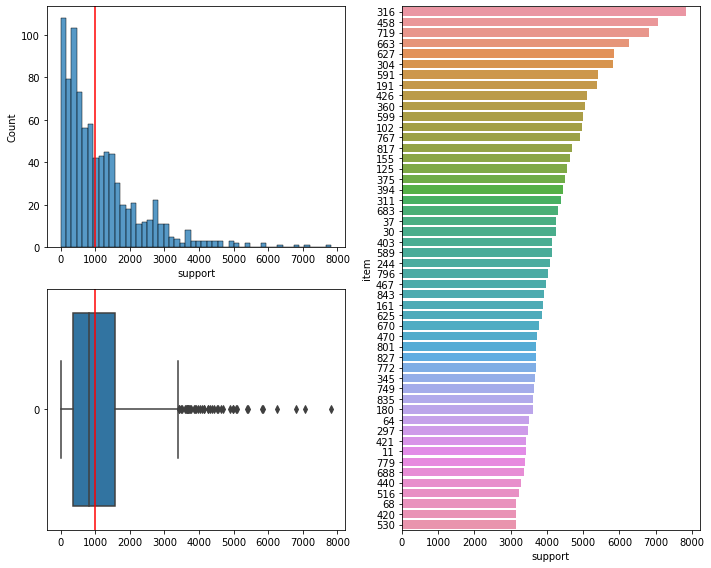

In [310]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec

fig = plt.figure(figsize=(10, 8))

ax1= fig.add_subplot(2,2,1)
ax2= fig.add_subplot(2,2,3)
ax3= fig.add_subplot(1,2,2)

# set s and threshold
s = 0.01
threshold = s * get_number_of_baskets(baskets)

sns.histplot(data=df['support'], bins=50, ax=ax1)
ax1.axvline(x=threshold, color='r')
sns.boxplot(data=df['support'], orient='h', ax=ax2)
ax2.axvline(x=threshold, color='r')
barplot_max_no_of_baskets = 50
sns.barplot(data=df.sort_values(by='support', ascending=False).head(barplot_max_no_of_baskets),
            x='support', 
            y='item', 
            orient='h',
            order=df.sort_values(by='support', ascending=False).item.head(barplot_max_no_of_baskets),
            ax=ax3
            )

plt.tight_layout()
plt.show()


## Monotonicity of Itemsets

According to the paper and ch 6 of the course literature, the effectiveness of the Apriori algorithm depends on the monotonicity of the itemsets. 

> **Definition**: If a set $I$ of items is frequent, then so is the powerset of $I$ are also frequent (remember, the **powerset of $I$ is the set of all subsets of $I$**)

For example, if the itemset $I = \{1, 2, 3\}$ is frequent, then so are *all* subsets, $\mathscr{P}(I) = \{\{1\}, \{2\}, \{3\}, \{1, 2\}, \{1, 3\}, \{3, 2\}\}$, of $I$.
In section 6.2.5 of the course literature, there is a naive algorithm for finding frequent itemsets described. The algorithm is as follows:

In [311]:
def count_all_pairs_naive(baskets):
    """
    Count the number of pairs of items that occur together in a basket.
    """
    pairs = {}
    for basket in baskets:
        for item1 in basket:
            for item2 in basket:
                if item1 < item2: # TODO check if this is correct, not sure
                    pairs[(item1, item2)] = pairs.get((item1, item2), 0) + 1
    return pairs

tuples = count_all_pairs_naive(baskets)


For the dataset included in the lab, the algorithm takes 2.5 seconds to run. The algorithm is not very efficient, as it has to check every possible subset of every itemset. The Apriori algorithm is much more efficient, as it only checks the subsets of the itemsets that are frequent. The Apriori algorithm is described in section 6.2.6 of the course literature, but also in the article. 

In [312]:
def get_support_for_all_pairs(items):
    return dict(map(lambda x: (x[0], len(x[1])), items.items()))

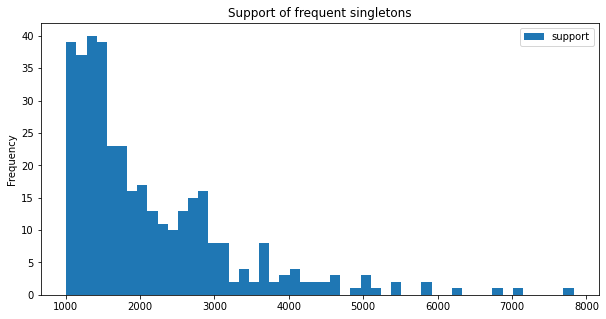

In [313]:
# first step of the aprori algorithm is to count the number singletons, which we already did (?)
# TODO here I overwrite the previous defintion of 'singletons', and I believe this is better.
singletons = get_support_for_all_pairs(items)

# between the passes of A-Priori, we will store the frequent singletons in 'frequent_singletons'
df_singletons = pd.DataFrame.from_dict(singletons, orient='index', columns=['support'])

# we can now filter out all singletons that do not meet the threshold
df_freq_singletons = df_singletons[df_singletons['support'] >= s * get_number_of_baskets(baskets)]

# make a histplot of the support of the singletons above the threshold
df_freq_singletons.plot(kind='hist', bins=50, figsize=(10, 5)).set_title('Support of frequent singletons');

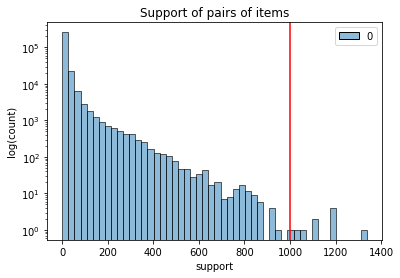

In [314]:
# plot the distribution of the support of the pairs

# TODO Threshold is off for pairs #FML
plot = sns.histplot(data=tuples.values(), bins=50)
plot.set(xlabel='support', ylabel='log(count)', title='Support of pairs of items')
plot.set_yscale('log')

# add a red vertical line at the threshold
plot.axvline(x=threshold, color='r')

For the second pass of the Apriori algorithm, we need to generate candidate itemsets. 

> **From course literature (p.226):** During the second pass, we count all the pairs that *consists of two frequent items*. We call this table *frequent-items table*.

We then check if the pair is frequent, and if it is, we add it to the set of frequent itemsets.
The algorithm for generating candidate itemsets is as follows:

In [315]:
freq_singletons = list(zip(df_freq_singletons.index, df_freq_singletons['support']))

In [316]:
def get_frequent_items_table(baskets, freq_singletons):
    """
    Returns a table of frequent items, where each row is a frequent item and each column is a basket.
    """
    num_of_items = len(get_unique_items(baskets))
    frequent_items_table = np.zeros(1000, dtype=int)

    # assign 'm' as a unique values, used to mark the frequent items
    m = 0

    # identify all frequent items
    for item, freq in freq_singletons:
        frequent_items_table[item] = m
        m += 1
    return frequent_items_table

Now we do the 2nd pass of the Apriori algorithm, where we check if the candidate itemsets are frequent.

From the course literature, page 226:

1. For each basket, look in the frequent-items table to see which of its items are frequent.
2. In a double loop, generate all pairs of frequint items in that basket.
3. For each such pair, add one to its count in the data structure used to store counts.

To generate all pairs of frequent items in a basket, we use the `combinations` function from the `itertools` library. We use `frozensets` since they are a hashable type, and can be used as keys in a dictionary.

In [317]:
from itertools import combinations

def get_frequent_item_from_basket(basket, frequent_items_table):
    """
    [HELPER FUNCTION] Return the frequent items in a basket.
    """
    return [item for item in basket if frequent_items_table[item] != 0]

def generate_all_combinations(items, k=2):
    """
    [HELPER FUNCTION] Generate all pairs of frequent items in a basket.
    """
    return [frozenset(pair) for pair in combinations(items, k)]

def find_candidate_pairs(baskets, frequent_items_table, k=2):
    """
    Find all candidate pairs of frequent items.
    """
    candidate_pairs = {}
    for basket in baskets:
        freq_items_in_basket = get_frequent_item_from_basket(basket, frequent_items_table)
        basket_pairs = generate_all_combinations(freq_items_in_basket, k=k)
        for pair in basket_pairs:
            if pair not in candidate_pairs:
                candidate_pairs[pair] = 1
            else:
                candidate_pairs[pair] += 1
    return candidate_pairs


def filter_candidate_pairs(candidate_pairs, threshold):
    """
    Filter out all candidate pairs that do not meet the threshold.
    """
    #return dict(filter(lambda x: x[1] >= threshold, candidate_pairs.items())) # TODO är filter bättre?
    return {pair: freq for pair, freq in candidate_pairs.items() if freq >= threshold}

Here I try to filter all the frequent itemsets that have a support of 0.01 or higher. I do this by creating a new dictionary where I only add the frequent itemsets that have a support of 0.01 or higher. I then sort the dictionary by the support of the itemsets.

In [318]:
frequent_items_table = get_frequent_items_table(baskets, freq_singletons)
candidate_pairs = find_candidate_pairs(baskets, frequent_items_table)

# TODO uncertain if this is correct
threshold = int(0.01 * len(candidate_pairs))
print(f'Number of candidate pairs: {len(candidate_pairs)}, and threshold: {threshold}')

frequent_candidate_pairs = filter_candidate_pairs(candidate_pairs, threshold)

Number of candidate pairs: 69751, and threshold: 697


WHEN YOU LOOK CLOSE ENOUGH EVERYTHING IS A HEATMAP

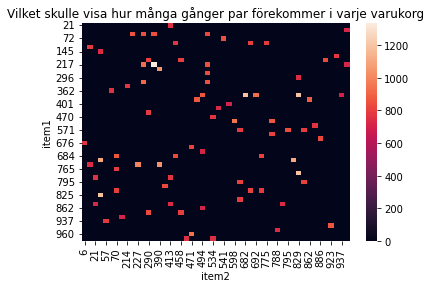

In [319]:
%matplotlib inline

# 'unboxed' is the dictionary with frozensets, unwrapped into a matrix
unboxed = []
for item in frequent_candidate_pairs.items():
    x, y = item[0]
    count = item[1]
    unboxed.append((x, y, count))

# Hettkarta över antal förekomster av par
df = pd.DataFrame(unboxed, columns=['item1', 'item2', 'support'])
sns.heatmap(df.pivot_table(index='item1', columns='item2', values='support').fillna(0)).set_title('Vilket skulle visa hur många gånger par förekommer i varje varukorg');

## Apriori Pipeline

![Apriori pipeline](../imgs/apriori_pipeline.jpeg)

I think next step is to implement the Apriori algorithm in Spark. I think it would be interesting to see how the performance of the algorithm changes when we use Spark instead of Python.
No but make a pipeline that returns most frequent pairs as described in the image.

In [320]:
# construct a pipeline as described in the course material
# TODO perhaps makes more sense to make it a class?
# TODO namnge first pass och second pass tydligt i koden...
def apriori_pipeline(items, basket, s=0.01, pipeline_length=2):
    items = item_and_basket_dictionary(baskets)
    singletons = get_support_for_all_pairs(items) # TODO fult namn och fel att ha i Pajplajnen? Borde returnera en df direkt
    df_singletons = pd.DataFrame.from_dict(singletons, orient='index', columns=['support'])
    df_freq_singletons = df_singletons[df_singletons['support'] >= s * get_number_of_baskets(baskets)]
    freq_singletons = list(zip(df_freq_singletons.index, df_freq_singletons['support']))
    frequent_items_table = get_frequent_items_table(baskets, freq_singletons)
    candidate_pairs = find_candidate_pairs(baskets, frequent_items_table)
    threshold = int(s * len(candidate_pairs))
    frequent_candidate_pairs = filter_candidate_pairs(candidate_pairs, threshold)
    return frequent_candidate_pairs

In [321]:
apriori_pipeline(items, baskets)

{frozenset({448, 538}): 723,
 frozenset({39, 704}): 1107,
 frozenset({704, 825}): 1102,
 frozenset({39, 825}): 1187,
 frozenset({529, 782}): 862,
 frozenset({227, 390}): 1049,
 frozenset({623, 795}): 805,
 frozenset({795, 853}): 806,
 frozenset({571, 795}): 838,
 frozenset({175, 910}): 713,
 frozenset({623, 853}): 791,
 frozenset({571, 623}): 783,
 frozenset({571, 853}): 793,
 frozenset({392, 862}): 881,
 frozenset({411, 803}): 826,
 frozenset({290, 458}): 786,
 frozenset({208, 290}): 803,
 frozenset({290, 888}): 826,
 frozenset({208, 458}): 796,
 frozenset({458, 888}): 796,
 frozenset({208, 888}): 829,
 frozenset({192, 935}): 775,
 frozenset({471, 678}): 810,
 frozenset({789, 829}): 1194,
 frozenset({296, 829}): 736,
 frozenset({392, 489}): 866,
 frozenset({368, 829}): 1194,
 frozenset({72, 541}): 846,
 frozenset({368, 937}): 701,
 frozenset({6, 676}): 769,
 frozenset({21, 857}): 729,
 frozenset({21, 793}): 765,
 frozenset({793, 857}): 734,
 frozenset({598, 782}): 800,
 frozenset({529